<a href="https://colab.research.google.com/github/Gaurav-phatkare/BERT_Model-NLP/blob/main/Twitter_Sentiment_Analysis_Using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install kaggle

In [3]:
!mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d kazanova/sentiment140

 94% 76.0M/80.9M [00:02<00:00, 39.5MB/s]
100% 80.9M/80.9M [00:02<00:00, 31.2MB/s]


In [7]:
!unzip /content/sentiment140.zip

Archive:  /content/sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [8]:
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding='latin-1', header = None)

In [9]:
df.columns=['Sentiment', 'id', 'Date', 'Query', 'User', 'Tweet']

In [10]:
df = df.drop(columns=['id', 'Date', 'Query', 'User'], axis=1)

In [11]:
df.head()

,Sentiment,Tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [12]:
# df = df.rename(columns={df.columns[0]: 'target', df.columns[1]: 'id', df.columns[2]: 'date', df.columns[3]: 'query', df.columns[4]: 'username', df.columns[5]: 'content'})

In [13]:
df.shape

(1600000, 2)

In [14]:
df = df.sample(250000)

In [15]:
df['labels'] = df['Sentiment'].replace([0, 4],['Negative','Positive'])

In [16]:
df.Sentiment.value_counts()

0    125153
4    124847
Name: Sentiment, dtype: int64

In [17]:
df['Sentiment'] = df.Sentiment.replace(4,1)

In [18]:
df.Sentiment.value_counts()

0    125153
1    124847
Name: Sentiment, dtype: int64

#Data Cleaning

In [19]:
import re

hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"https?://\S+")

def process_text(text):
    text = re.sub(r'http\S+', '', text)
    text = hashtags.sub(' hashtag', text)
    # text = mentions.sub(' entity', text)
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    return text.strip().lower()

In [20]:
df['Tweet'] = df.Tweet.apply(process_text)

In [21]:
df['Tweet'].head()

1215151                          - you look beautiful, miley
699119           standing in line at beerfest.  no booze yet
1549126    had a &quot;follower&quot; get suspended.  tha...
569854                                     i feel like shit.
1086473                                  whatupwhatupwhatup!
Name: Tweet, dtype: object

In [22]:
df['Tweet'][-5:].values

array(['dads ditching me for his gf  lol offf to plantation to vibe with keianna and torrance; i miss my old crew.',
       'actually i used that &quot;translate page&quot; on my yahoo toolbar &amp; it translates it fine. yes, thank you russia!!',
       'i loved spiderwick!', 'i start in september  cant wait',
       'so sometime by next pay check? you better come  this is a personal invite'],
      dtype=object)

In [23]:
df.drop_duplicates(subset='Tweet',inplace=True)

In [24]:
df.shape

(244711, 3)

In [25]:
text_len = []
for text in df.Tweet:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [26]:
df['text_len'] = text_len

In [27]:
df.head()

,Sentiment,Tweet,labels,text_len
1215151,1,"- you look beautiful, miley",Positive,5
699119,0,standing in line at beerfest. no booze yet,Negative,8
1549126,1,had a &quot;follower&quot; get suspended. tha...,Positive,10
569854,0,i feel like shit.,Negative,4
1086473,1,whatupwhatupwhatup!,Positive,1


In [28]:
df = df[df['text_len'] > 4]

In [29]:
df.shape

(219071, 4)

In [30]:
from sklearn.model_selection import train_test_split
training_data, testing_data = train_test_split(df, test_size=0.2, random_state=25)

In [31]:
training_data.shape, testing_data.shape

((175256, 4), (43815, 4))

In [32]:
import tensorflow as tf
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.2 MB/s eta 0:00:00


In [33]:
from transformers import BertTokenizerFast
from transformers import TFBertModel

In [34]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [35]:
token_lens = []

for txt in training_data['Tweet'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)

In [36]:
max_len

160

In [37]:
training_data['token_lens'] = token_lens

In [38]:
training_df = training_data.sort_values(by='token_lens', ascending=False)

In [39]:
training_df[:1000]

,Sentiment,Tweet,labels,text_len,token_lens
1286976,1,things â ñ?ñð¾ ððµññ! ð¡ñð¼ðµð» ñð°ð·...,Positive,21,160
1451195,1,ðñð¾ ð¿ð¾ð´ñ?ñð°ð²ðºð¸: ð² ð­ð»ð¸ñ-ð²ðµññ...,Positive,21,144
1363821,1,ð¥ð¾ñðµð» ð±ñ ñ? ñ?ðµð±ðµ ñð°ðºð¾ð¹ ð¼ð¾ð½ð...,Positive,22,133
1436377,1,"on our way back home, yay!!!!!!!!!!!!!!!!!!!!!...",Positive,6,122
1451747,1,ð¡ ñð´ð¾ð²ð¾ð»ññ?ñð²ð¸ðµð¼ ð±ñ ð¿ð¾ñð¸ñð...,Positive,19,114
...,...,...,...,...,...
221679,0,i'm tired of the sun. it's not going away for...,Negative,30,47
1505133,1,my ankle is trobbing. tequilla helps a loottt ...,Positive,27,47
426380,0,i hope thereâ´s no boy at our school starting ...,Negative,27,47
494354,0,maybe you're just really tired &amp; need to r...,Negative,23,47


In [40]:
training_df = training_df.iloc[1000:]

In [41]:
training_df.shape

(174256, 5)

In [42]:
training_df = training_df.sample(frac=1).reset_index(drop=True)

<ipython-input-43-35caff79e668>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(training_df['token_lens'])


<Axes: xlabel='token_lens', ylabel='Density'>

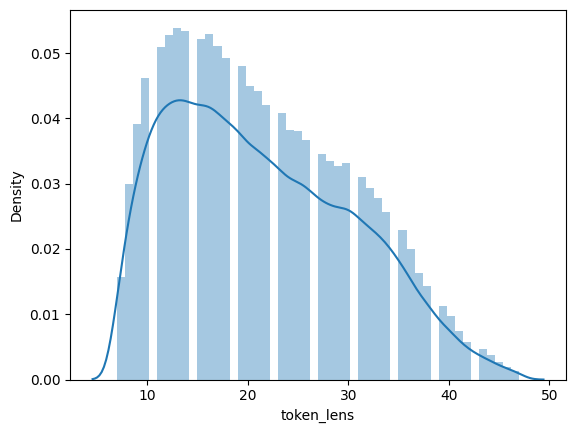

In [43]:
sns.distplot(training_df['token_lens'])

In [44]:
token_lens_test = []

for txt in testing_data['Tweet'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))

max_len=np.max(token_lens_test)

In [45]:
max_len

122

In [46]:
testing_data['token_lens'] = token_lens_test

In [47]:
testing_df = testing_data.sort_values(by='token_lens', ascending=False)
testing_df.head(1000)

,Sentiment,Tweet,labels,text_len,token_lens
1429252,1,ñð°ñ?ñ?ñð»ðºð° ð¿ñð¾ ð¾ñð´ññ ð½ð° ðð°ð»...,Positive,19,122
1224729,1,ø§ùø§ ù ø¹ù ù?ù ø§ùùùø·ø© ùø°ù ø ø§ø´...,Positive,23,117
107902,0,2 ngï¿½y ngh? l?i s?p h?t hï¿½m qua thï¿½ c? ...,Negative,32,99
1090219,1,? ???? - ?? ?? ??????. ???? ?????????? ??? ? ?...,Positive,25,93
1320268,1,íë²ë ë¹ì§ëì¤ ì¤ì¿¨ íì?ë¤ì?´ ì¡°...,Positive,25,90
...,...,...,...,...,...
1494821,1,ok-dont spread that word - bad idea btw- ur p...,Positive,27,41
441529,0,we were on a new kids on the block sleepover l...,Negative,26,41
1276206,1,left her phone at home. if you need to contact...,Positive,24,41
667411,0,i'm so stupid! (yes you're) the boy that i lov...,Negative,25,41


In [48]:
testing_df = testing_df.iloc[1000:]
testing_df.head(10)

,Sentiment,Tweet,labels,text_len,token_lens
126683,0,going out today! just got to drag myself into ...,Negative,25,41
27301,0,oh no dawson! they're still not sure if it's ...,Negative,21,41
288961,0,i think you told me to play l4d. i did. i didn...,Negative,26,41
1220605,1,"excellent aye, had a good one - got out in t...",Positive,30,41
1256508,1,it's been quite a day.! excuse the mess press ...,Positive,23,41
545287,0,finished day 1 of a 3 day fast... not liking h...,Negative,25,41
36561,0,"busy already fd wants to burn today, day job...",Negative,29,41
683042,0,overnight in lorain &amp; i forgot my bi-pap m...,Negative,27,41
182879,0,if i'm not on.watching johnnylingo.she told me...,Negative,24,41
759993,0,when does that bruno film come out? wanna see ...,Negative,26,41


In [49]:
testing_df = testing_df.sample(frac=1).reset_index(drop=True)

In [50]:
testing_df.head(10)

,Sentiment,Tweet,labels,text_len,token_lens
0,1,8 more days before school begins. yey! im exci...,Positive,9,15
1,1,"no, i kept the really loud one.",Positive,7,11
2,1,and you have some fic rec? wanna help writing?...,Positive,15,22
3,1,i know the feeling...trust! hope u get it reso...,Positive,17,26
4,1,"yepp, and da vinci code also - i'm very much i...",Positive,25,32
5,1,quigley down under is on again. think i'll pas...,Positive,17,25
6,1,i'm not sure that a lot of them even watch ope...,Positive,12,16
7,0,good morning how is everyone? on my way to see...,Negative,22,27
8,0,"got a summer cold tylenol, get into my belly!!",Negative,9,16
9,1,good job i'm a disciplined person,Positive,6,10


In [51]:
training_df.Sentiment.value_counts()

0    88984
1    85272
Name: Sentiment, dtype: int64

In [52]:
X = training_df['Tweet'].values
y = training_df['Sentiment'].values

In [53]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [54]:
X_test = testing_df['Tweet'].values
y_test = testing_df['Sentiment'].values

In [55]:
X_train.shape[0], X_val.shape, X_test.shape

(139404, (34852,), (42815,))

# One Hot Encoding

In [56]:
y_train_le = y_train.copy()
y_valid_le = y_val.copy()
y_test_le = y_test.copy()

In [57]:
from sklearn import preprocessing

OneHot = preprocessing.OneHotEncoder()
y_train = OneHot.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val = OneHot.fit_transform(np.array(y_val).reshape(-1, 1)).toarray()
y_test = OneHot.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

# Baseline Model With Naive Bayes and TFIDF

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


# Create tokenization and modelling pipeline

model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf',MultinomialNB())
])

# fit the pipeline to the training data

model_0.fit(X_train, y_train_le)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [59]:
# baseline_score = model_0.score(X_val, y_val)

In [60]:
# baseline_score

In [61]:
test_pred = model_0.predict(X_test)

In [62]:
y_test_le

array([1, 1, 1, ..., 1, 0, 0])

In [63]:
# make helper function for accuracy precision recall and f1 score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le, test_pred, target_names = ['Negative', 'Positive']))




	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.74      0.81      0.77     21817
    Positive       0.78      0.70      0.74     20998

    accuracy                           0.75     42815
   macro avg       0.76      0.75      0.75     42815
weighted avg       0.76      0.75      0.75     42815



#BERT Sentiment Analysis

In [64]:
Max_len = 100

In [65]:
def tokenize(data, max_len = Max_len):
  input_ids = []
  attention_masks = []

  for i in range(len(data)):
    encoded = tokenizer.encode_plus(
    data[i],
    add_special_tokens = True,
    max_length = max_len,
    padding = 'max_length',
    return_attention_mask = True
    )

    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])

  return np.array(input_ids), np.array(attention_masks)

In [66]:
train_input_ids, train_attention_masks = tokenize(X_train, Max_len)
val_input_ids, val_attention_masks = tokenize(X_val, Max_len)
test_input_ids, test_attention_masks = tokenize(X_test, Max_len)


In [67]:
len(train_input_ids)

139404

In [68]:
# # Reshape the input tensors to 2D
# train_input_ids = np.expand_dims(train_input_ids, axis=-1)
# train_attention_masks = np.expand_dims(train_attention_masks, axis=-1)
# val_input_ids = np.expand_dims(val_input_ids, axis=-1)
# val_attention_masks = np.expand_dims(val_attention_masks, axis=-1)
# test_input_ids = np.expand_dims(test_input_ids, axis=-1)
# test_attention_masks = np.expand_dims(test_attention_masks, axis=-1)

In [69]:
# train_input_ids.shape

In [70]:
# input_data = [train_input_ids,  train_attention_masks]

In [71]:
# type(y_train)

In [72]:
train_tf_data = tf.data.Dataset.from_tensor_slices((train_input_ids,  train_attention_masks))
train_tf_labels = tf.data.Dataset.from_tensor_slices(y_train)
train_tf_dataset = tf.data.Dataset.zip((train_tf_data, train_tf_labels))
train_tf_dataset = train_tf_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [73]:
val_tf_data = tf.data.Dataset.from_tensor_slices((val_input_ids,  val_attention_masks))
val_tf_labels = tf.data.Dataset.from_tensor_slices(y_val)
val_tf_dataset = tf.data.Dataset.zip((val_tf_data, val_tf_labels))
val_tf_dataset = val_tf_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [86]:
test_tf_data = tf.data.Dataset.from_tensor_slices((test_input_ids,  test_attention_masks))
test_tf_labels = tf.data.Dataset.from_tensor_slices(y_test)
test_tf_dataset = tf.data.Dataset.zip((test_tf_data, test_tf_labels))
test_tf_dataset = test_tf_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [80]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [81]:
# let build the model

input_ids = tf.keras.Input(shape = (Max_len,), dtype = 'int32')
attention_masks = tf.keras.Input(shape = (Max_len,), dtype = 'int32')

embeddings = bert_model([input_ids, attention_masks])[1]
# x = tf.keras.layers.Flatten()(embeddings)
output = tf.keras.layers.Dense(2, activation = 'softmax')(embeddings)

model = tf.keras.models.Model(inputs = [input_ids, attention_masks],
                              outputs = output)

In [82]:
# def create_model(bert_model, max_len = Max_len):
#   opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
#   loss = tf.keras.losses.CategoricalCrossentropy()
#   accuracy = tf.keras.metrics.CategoricalAccuracy()


#   input_ids = tf.keras.Input(shape = (Max_len,), dtype = 'int32')
#   attention_masks = tf.keras.Input(shape = (Max_len,), dtype = 'int32')

#   embeddings = bert_model([input_ids, attention_masks])[1]

#   output = tf.keras.layers.Dense(2, activation = 'softmax')(embeddings)

#   model = tf.keras.models.Model(inputs = [input_ids, attention_masks],
#                               outputs = output)

#   model.compile(opt, loss = loss, metrics = accuracy)

#   return model




In [83]:
# compile the model
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=tf.keras.metrics.CategoricalAccuracy())

In [84]:
# model = create_model(bert_model, Max_len)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                         

In [340]:
history_bert_model = model.fit([train_input_ids,train_attention_masks], y_train,
                               validation_data =([val_input_ids,val_attention_masks], y_val),
                              #  steps_per_epoch = int(0.1 * len(train_tf_dataset)),
                               epochs = 4,
                               batch_size = 32)
                              #  validation_steps = int(0.1 * len(val_tf_dataset)))

Epoch 1/4
852/852 [==============================] - 655s 662ms/step - loss: 0.4430 - categorical_accuracy: 0.7940 - val_loss: 0.3930 - val_categorical_accuracy: 0.8229
Epoch 2/4
852/852 [==============================] - 594s 698ms/step - loss: 0.3366 - categorical_accuracy: 0.8538 - val_loss: 0.3931 - val_categorical_accuracy: 0.8237
Epoch 3/4
852/852 [==============================] - 595s 698ms/step - loss: 0.2511 - categorical_accuracy: 0.9009 - val_loss: 0.4249 - val_categorical_accuracy: 0.8245
Epoch 4/4
852/852 [==============================] - 595s 698ms/step - loss: 0.1641 - categorical_accuracy: 0.9392 - val_loss: 0.5415 - val_categorical_accuracy: 0.8220


In [412]:
history_bert_model = model.fit(train_tf_dataset,
                               validation_data =val_tf_dataset,
                               steps_per_epoch = int(0.2 * len(train_tf_dataset)),
                               epochs = 4,
                               validation_steps = int(0.2 * len(val_tf_dataset)))

Epoch 1/4
170/170 [==============================] - 170s 704ms/step - loss: 0.5465 - categorical_accuracy: 0.7254 - val_loss: 0.4572 - val_categorical_accuracy: 0.7932
Epoch 2/4
170/170 [==============================] - 113s 664ms/step - loss: 0.4463 - categorical_accuracy: 0.7892 - val_loss: 0.4338 - val_categorical_accuracy: 0.7984
Epoch 3/4
170/170 [==============================] - 111s 656ms/step - loss: 0.4174 - categorical_accuracy: 0.8149 - val_loss: 0.4206 - val_categorical_accuracy: 0.8125
Epoch 4/4
170/170 [==============================] - 113s 663ms/step - loss: 0.4112 - categorical_accuracy: 0.8145 - val_loss: 0.4010 - val_categorical_accuracy: 0.8214


In [85]:
history_bert_model = model.fit(train_tf_dataset,
                               validation_data =val_tf_dataset,
                               steps_per_epoch = int(0.1 * len(train_tf_dataset)),
                               epochs = 4,
                               validation_steps = int(0.1 * len(val_tf_dataset)))

Epoch 1/4
435/435 [==============================] - 349s 678ms/step - loss: 0.4711 - categorical_accuracy: 0.7753 - val_loss: 0.4337 - val_categorical_accuracy: 0.8068
Epoch 2/4
435/435 [==============================] - 290s 667ms/step - loss: 0.3988 - categorical_accuracy: 0.8193 - val_loss: 0.3918 - val_categorical_accuracy: 0.8263
Epoch 3/4
435/435 [==============================] - 306s 704ms/step - loss: 0.3941 - categorical_accuracy: 0.8216 - val_loss: 0.3825 - val_categorical_accuracy: 0.8314
Epoch 4/4
435/435 [==============================] - 290s 667ms/step - loss: 0.3813 - categorical_accuracy: 0.8282 - val_loss: 0.3713 - val_categorical_accuracy: 0.8392


In [87]:
test_tf_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 100), dtype=tf.int64, name=None), TensorSpec(shape=(None, 100), dtype=tf.int64, name=None)), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))>

In [89]:
test_pred_probs = model.predict(test_tf_dataset, verbose = 1)

1338/1338 [==============================] - 298s 223ms/step


In [90]:
test_pred_probs

array([[0.08255729, 0.9174427 ],
       [0.40945795, 0.5905421 ],
       [0.10366258, 0.89633745],
       ...,
       [0.03692148, 0.96307844],
       [0.37920263, 0.6207974 ],
       [0.83915573, 0.16084419]], dtype=float32)

In [91]:
test_pred = tf.argmax(test_pred_probs, axis = 1)
test_pred[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 1, 1, 1, 1, 1, 0, 1, 0, 1])>

In [92]:
y_test_le

array([1, 1, 1, ..., 1, 0, 0])

In [93]:
# function for accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def calculate_results(y_true, y_pred):
  """
  calculate model acuracy, precision, recall and f1 score of a binary classification model
  """
  # calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # calculat model precision, recall and f1-score using weigthed average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred,average = 'weighted' )

  model_results = {

                   'accuracy' :model_accuracy,
                   'precision':model_precision,
                   'recall' : model_recall,
                   'f1' : model_f1
  }
  return model_results

In [95]:
test_result = calculate_results(y_test_le, test_pred)

In [96]:
test_result

{'accuracy': 83.93553661100081,
 'precision': 0.8393777164388414,
 'recall': 0.8393553661100082,
 'f1': 0.8393617769578061}